# Machine Learning Engineer Nanodegree

## Introduction

Since taxi companies use vehicle's allocated time and trip distance to charge the passenger's trip, be able to predict the price of trip based on this information helps in the audit process, estimates of the company's profit or even charge the passenger before the trip, like Uber.

With information of every trip about when and where the passenger were picked up and droped off and how many passengers triped will allow the company to estimate how many time vehicle will be allocated and, based on that information, how much passenger should pay.

## Importing dependencies

In [1]:
%matplotlib inline
from datetime import datetime
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from geopy import distance

import csv
import numpy as np
import pandas as pd
import xgboost as xgb

### Defining constants

In [2]:
train_file = 'dataset/train.csv'
test_file = 'dataset/test.csv'

### Defining functions

In [3]:
def rmsle(real, predicted):
    sum = 0.0
    real = np.array(y_test)
    predicted = np.array(y_pred)

    for x in range(len(predicted)):
        if predicted[x] >= 0 and real[x] >= 0:
            p = np.log(predicted[x] + 1)
            r = np.log(real[x] + 1)
            sum = sum + (p - r) ** 2

    return (sum / len(predicted)) ** 0.5

In [4]:
def calculate_distance(df):
    pickup = np.array(df[['pickup_latitude', 'pickup_longitude']])
    dropoff = np.array(df[['dropoff_latitude', 'dropoff_longitude']])
    df['pickup'] = [(row[0], row[1]) for row in pickup]
    df['dropoff'] = [(row[0], row[1]) for row in dropoff]
    
    return [distance.distance(row['pickup'], row['dropoff']).km for index, row in df.iterrows()]

In [5]:
def plot_duration_by_pickup_hour(data_frame, title):
    data_frame.groupby('pickup_hour').mean()['trip_duration'].plot(kind='bar', title=title);

In [6]:
def plot_duration_by_pickup_range(data_frame, title):
    group = pd.cut(data_frame['pickup_hour'], np.arange(0, 25, 6))
    data_frame.groupby(group).mean()['trip_duration'].plot(kind='bar', title=title);

In [7]:
def plot_duration_by_passenger_count(data_frame, title):
    data_frame.groupby('passenger_count').mean()['trip_duration'].plot(kind='bar', title=title);

In [8]:
def plot_duration_by_distance(data_frame, title):
    group = pd.cut(data_frame['distance'], np.arange(0, 7, 1))
    data_frame.groupby(group).mean()['trip_duration'].plot(kind='bar', title=title);

In [9]:
def plot_trips_by_pickup_range(data_frame, title):
    group = pd.cut(data_frame['pickup_hour'], np.arange(0, 25, 6))
    data_frame.groupby(group).count()['trip_duration'].plot(kind='bar', title=title);

## Read Data

In [10]:
df = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

## Cleaning data

### Adjusting pickup_datetime to datetime

In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])    

### Adjusting trip_duration to hours

In [12]:
df['trip_duration'] = df['trip_duration'] / 3600

### Create a new column with distance between pick up and drop off using geopy

In [13]:
df['distance'] = calculate_distance(df)

In [14]:
df_test['distance'] = calculate_distance(df_test)

### Normalize pick up time to consider just the hour

In [15]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df_test['pickup_hour'] = df_test['pickup_datetime'].dt.hour

### Adjust DataFrame to improve visualization

In [16]:
# Removing unecessary columns
df.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'store_and_fwd_flag', 'pickup', 'dropoff'], inplace=True)
df_test.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'store_and_fwd_flag', 'pickup', 'dropoff'], inplace=True)

# Reording Data Frame columns
df = df[['pickup_hour', 'passenger_count', 'distance', 'trip_duration']]
df_test = df[['pickup_hour', 'passenger_count', 'distance']]

### Removing trip_duration outliers

In [17]:
q1 = df.trip_duration.quantile(0.25)
q3 = df.trip_duration.quantile(0.75)
iqr = q3 - q1

df = df.query('(@q1 - 1.5 * @iqr) <= trip_duration <= (@q3 + 1.5 * @iqr)')

### Removing distance outliers

In [18]:
q1 = df.distance.quantile(0.25)
q3 = df.distance.quantile(0.75)
iqr = q3 - q1

df = df.query('(@q1 - 1.5 * @iqr) <= distance <= (@q3 + 1.5 * @iqr)')

### Drop duplicated records

In [19]:
df.drop_duplicates(inplace=True)

## Exporting clean dataset

## Relate distance, hour and number of passenger with time duration using histograms

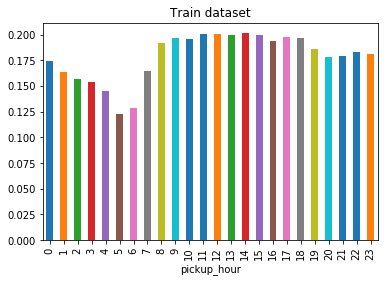

In [21]:
plot_duration_by_pickup_hour(df, 'Train dataset')

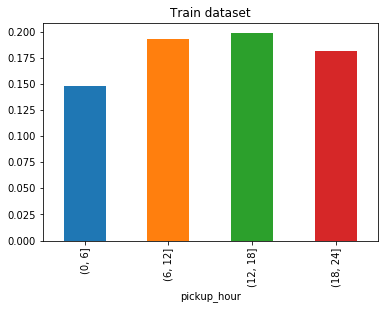

In [22]:
plot_duration_by_pickup_range(df, 'Train dataset')

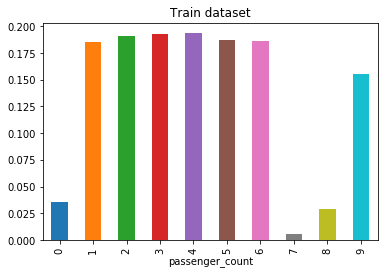

In [23]:
plot_duration_by_passenger_count(df, 'Train dataset')

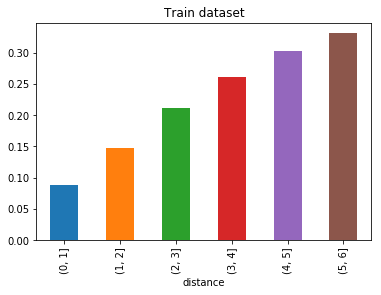

In [24]:
plot_duration_by_distance(df, 'Train dataset')

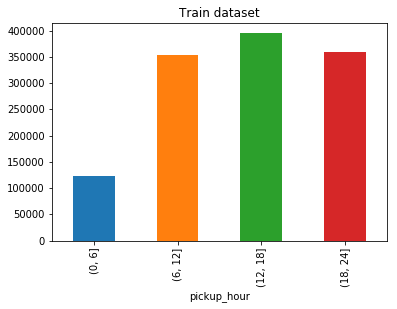

In [25]:
plot_trips_by_pickup_range(df, 'Train dataset')

## Splitting Data

In [26]:
# Removing trip duration from Data Frame
trip_duration = df.trip_duration
features = df.drop('trip_duration', axis = 1)

# Splitting dataset among train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, trip_duration, test_size=0.2, random_state=3)

## Train and Test MLPRegressor to find the best configuration

In [27]:
regressor = MLPRegressor(
    activation = 'logistic',
    random_state = 300
)

regressor = regressor.fit(X_train, y_train)

In [28]:
y_pred = regressor.predict(X_test);

## Take the evaluate metric to compare with benchmark 

In [29]:
metric = rmsle(y_test, y_pred)

print("Evaluated metric: %.4f" % metric)

Evaluated metric: 0.0608


## Benchmark

In [30]:
params = {
    'booster': 'gbtree',
    'objective': 'reg:linear',
    'learning_rate': 0.1,
    'max_depth': 14,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'silent': 1
}

## train model
dtrain = xgb.DMatrix(X_train, np.log(y_train + 1))
gbm = xgb.train(params, dtrain, num_boost_round = 100)

## Predict
y_pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1
metric = rmsle(y_test, y_pred)

print("Evaluated metric: %.4f" % metric)

Evaluated metric: 0.0599


## Validation

In [31]:
y_pred_test = regressor.predict(df_test)

In [32]:
y_pred_bench = np.exp(gbm.predict(xgb.DMatrix(df_test))) - 1

In [33]:
df_pred = df_test.copy()
df_pred['trip_duration'] = y_pred_test[:]

In [34]:
df_bench = df_test.copy()
df_bench['trip_duration'] = y_pred_bench[:]

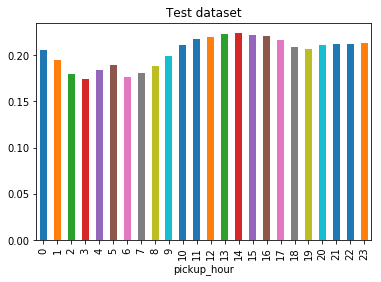

In [35]:
plot_duration_by_pickup_hour(df_pred, 'Test dataset')

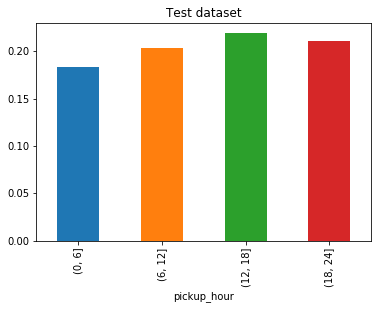

In [36]:
plot_duration_by_pickup_range(df_pred, 'Test dataset')

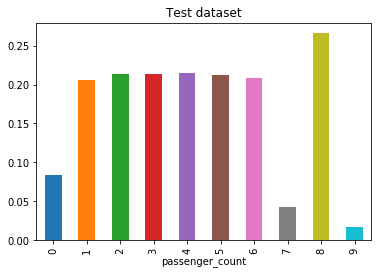

In [37]:
plot_duration_by_passenger_count(df_pred, 'Test dataset')

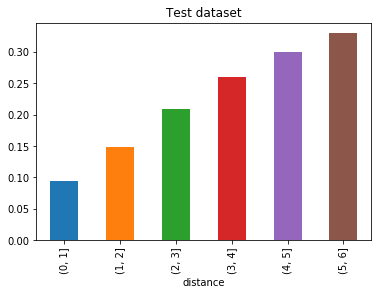

In [38]:
plot_duration_by_distance(df_pred, 'Test dataset')

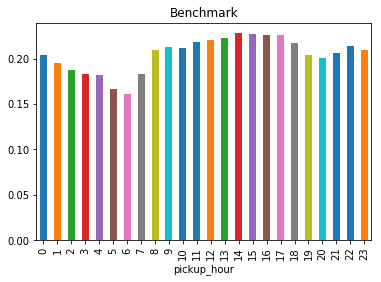

In [39]:
plot_duration_by_pickup_hour(df_bench, 'Benchmark')

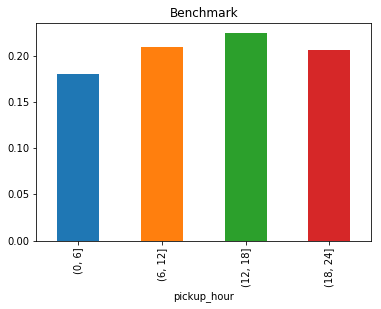

In [40]:
plot_duration_by_pickup_range(df_bench, 'Benchmark')

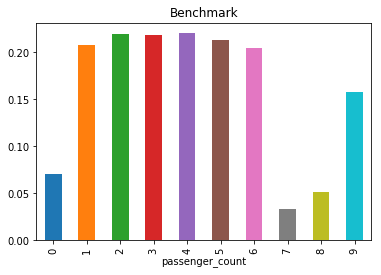

In [41]:
plot_duration_by_passenger_count(df_bench, 'Benchmark')

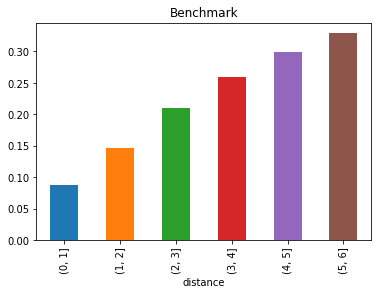

In [42]:
plot_duration_by_distance(df_bench, 'Benchmark')

In [43]:
df.describe()

,pickup_hour,passenger_count,distance,trip_duration
count,1.275828e+06,1.275828e+06,1.275828e+06,1.275828e+06
mean,1.367182e+01,1.659938e+00,2.250646e+00,1.862797e-01
std,6.328576e+00,1.312318e+00,1.475960e+00,1.105742e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,2.777778e-04
25%,9.000000e+00,1.000000e+00,1.147526e+00,1.019444e-01
50%,1.400000e+01,1.000000e+00,1.849074e+00,1.638889e-01
75%,1.900000e+01,2.000000e+00,2.994162e+00,2.486111e-01
max,2.300000e+01,9.000000e+00,6.915957e+00,5.811111e-01


In [44]:
df_pred.describe()

,pickup_hour,passenger_count,distance,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.360648e+01,1.664530e+00,3.442193e+00,2.082671e-01
std,6.399693e+00,1.314242e+00,4.300259e+00,9.587653e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.089182e-02
25%,9.000000e+00,1.000000e+00,1.232265e+00,1.309605e-01
50%,1.400000e+01,1.000000e+00,2.094045e+00,1.884473e-01
75%,1.900000e+01,2.000000e+00,3.874716e+00,2.777798e-01
max,2.300000e+01,9.000000e+00,1.240510e+03,7.194437e-01


In [45]:
df_bench.describe()

,pickup_hour,passenger_count,distance,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.360648e+01,1.664530e+00,3.442193e+00,2.101049e-01
std,6.399693e+00,1.314242e+00,4.300259e+00,1.046016e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.700723e-02
25%,9.000000e+00,1.000000e+00,1.232265e+00,1.264521e-01
50%,1.400000e+01,1.000000e+00,2.094045e+00,1.875079e-01
75%,1.900000e+01,2.000000e+00,3.874716e+00,2.802337e-01
max,2.300000e+01,9.000000e+00,1.240510e+03,5.070474e-01
